<a href="https://colab.research.google.com/github/iserath18/Site-Escola/blob/main/atividade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ccdproc


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.6/355.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.0 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=0f8ec80875032c999d95cbcf4ebe23345a50ba3d8ef5d3eb9ccbe67747ef04ea
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00


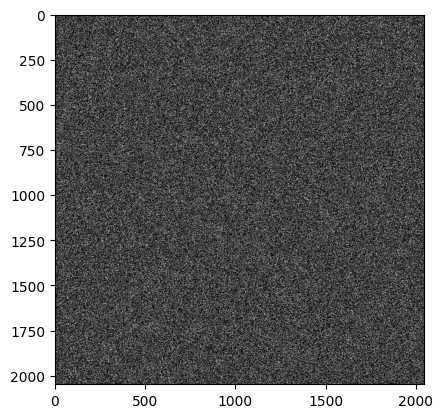

In [ ]:
from os import path
import ccdproc
import matplotlib
import numpy as np
from astropy.io import fits
from pathlib import Path
import astropy
import matplotlib.pyplot as plt

#converter header da pasta calibra

# Use Path from pathlib to create a Path object
dir_fits= Path('/content/drive/MyDrive/Colab Notebooks/calibracao /Calibra')

# Use the glob method to find all .fits files within the directory
arquivos_fits = dir_fits.glob('*.fits')

for arquivo in arquivos_fits:
    with fits.open(arquivo, mode='update') as hdul:
        header = hdul[0].header
        if 'EXPTIME' in header:
            exptime = header['EXPTIME']

            if isinstance(exptime, str) and ',' in exptime:

                exptime_corrigido = float(exptime.replace(',', '.'))

                header['EXPTIME'] = exptime_corrigido
                print(f"Corrigido EXPTIME em {arquivo.name}: {exptime} -> {exptime_corrigido}")

#converter header da pasta M27

# Use Path from pathlib to create a Path object
dir_fits= Path('/content/drive/MyDrive/Colab Notebooks/calibracao /M27')

# Use the glob method to find all .fits files within the directory
arquivos_fits = dir_fits.glob('*.fits')

for arquivo in arquivos_fits:
    with fits.open(arquivo, mode='update') as hdul:
        header = hdul[0].header
        if 'EXPTIME' in header:
            exptime = header['EXPTIME']

            if isinstance(exptime, str) and ',' in exptime:

                exptime_corrigido = float(exptime.replace(',', '.'))

                header['EXPTIME'] = exptime_corrigido
                print(f"Corrigido EXPTIME em {arquivo.name}: {exptime} -> {exptime_corrigido}")

#------------------------------------------------------------------------------------------#

#Atividade 1 - calibracao, fotometria e diagrama HR#

dir_salva = Path('/content/drive/MyDrive/Colab Notebooks/calibracao /dados processados ')
dir_fotos = Path('/content/drive/MyDrive/Colab Notebooks/calibracao /M27')    #Nome do dir com as fotos (galaxia NGC6872)
dir_calibra = Path('/content/drive/MyDrive/Colab Notebooks/calibracao /Calibra')
files = ccdproc.ImageFileCollection(dir_calibra)

files.summary['file', 'object', 'filter', 'exptime', 'naxis1', 'naxis2']

# cria o master bias #

lista_bias = files.files_filtered(object='Bias', include_path=True)

combined_bias = ccdproc.combine(lista_bias,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=astropy.stats.mad_std,
                             mem_limit=350e6, unit='adu'
                            )

combined_bias.meta['combined'] = True

combined_bias.write(dir_salva / 'combined_bias.fit', overwrite=True)

# Cria o master dark com o bias #


lista_dark = files.files_filtered(object='Dark', include_path=True)

combined_dark = ccdproc.combine(lista_dark,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=astropy.stats.mad_std,
                             mem_limit=350e6, unit='adu'
                            )

combined_dark.meta['combined'] = True

combined_dark.write(dir_salva / 'combined_dark.fit', overwrite=True)

# Cria o Flat #

#Subtrai o Dark
#Da lista de arquivos filtra os que tem objecte 'Flat', mas sem o path
lista_flat = files.files_filtered(object='Flat', include_path=False)

#Cria diretorio para salvar os flats
dir_salva_flat = Path('.', 'dados_processados')    #Nome do dir para salvar
dir_salva_flat.mkdir(exist_ok=True)        #Cria diretorio

for file_name in lista_flat:

    #Abre uma imagem:
    ccd = astropy.nddata.CCDData.read(dir_calibra / file_name, unit='adu')

    # Subtrai o bias
    ccd = ccdproc.subtract_bias(ccd, combined_bias)

    # Subtrai o dark sem bias, acerta a escala pois os tempos de exposicao sao diferentes
    ccd = ccdproc.subtract_dark(
    ccd,
    combined_dark,
    exposure_time='exptime',
    exposure_unit=astropy.units.second,
    scale=True)


    # Salva o resultado
    ccd.write(dir_salva_flat / file_name, overwrite=True)


#Acessa diretorio de dados salvos na variavel "files_flat"
files_flat = ccdproc.ImageFileCollection(dir_salva_flat)

#Obtem lista dos arquivos
lista_flat = files_flat.files_filtered(object='Flat', include_path=True)


#Obtem e mostra lista de filtros (cria um "set")
flat_filters = set(h['filter'] for h in files_flat.headers(object='Flat'))
flat_filters

#Repete operacao para todos os filtros
for filt in flat_filters:

    #Obtem lista de todos os arquivos flat do filtro "filt"
    to_combine = files_flat.files_filtered(object='Flat', filter=filt, include_path=True)

    #Combina as varias imagens usando media, com sigma clip (threshold=5) e limitacao do uso de memoria
    combined_flat = ccdproc.combine(to_combine,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                                 mem_limit=350e6
                                )

    #Muda o header do arquivo para combined = True
    combined_flat.meta['combined'] = True

    #Salva o arquivo combinado
    flat_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(dir_salva / flat_file_name, overwrite=True)


# CALIBRACAO FILTRO B #

ccdB = astropy.nddata.CCDData.read(dir_fotos / 'M27_B_003.fits', unit='adu')

reducedB = ccdproc.subtract_dark(ccdB, combined_dark,
                                  exposure_time='exptime', exposure_unit=astropy.units.second, scale=False)

flat = astropy.nddata.CCDData.read(dir_salva / "combined_flat_filter_B.fit", unit='adu')

reducedB = ccdproc.flat_correct(reducedB, flat)


reducedB.write(dir_salva / 'M27_B_003_calibrado.fits', overwrite=True)

# CALIBRACAO FILTRO I #


ccdI = astropy.nddata.CCDData.read(dir_fotos / 'M27_I_003.fits', unit='adu')

reducedI = ccdproc.subtract_dark(ccdI, combined_dark,
                                  exposure_time='exptime', exposure_unit=astropy.units.second, scale=False)

flat = astropy.nddata.CCDData.read(dir_salva / "combined_flat_filter_I.fit", unit='adu')

reducedI = ccdproc.flat_correct(reducedI, flat)

reducedI.write(dir_salva / 'M27_I_003_calibrado.fits', overwrite=True)


# CALIBRACAO FILTRO R #

ccdR = astropy.nddata.CCDData.read(dir_fotos / 'M27_R_003.fits', unit='adu')

reducedR = ccdproc.subtract_dark(ccdB, combined_dark,
                                  exposure_time='exptime', exposure_unit=astropy.units.second, scale=False)

flat = astropy.nddata.CCDData.read(dir_salva / "combined_flat_filter_R.fit", unit='adu')

reducedR = ccdproc.flat_correct(reducedR, flat)

reducedR.write(dir_salva / 'M27_R_003_calibrado.fits', overwrite=True)


### CALIBRACAO FILTRO V ###

ccdV = astropy.nddata.CCDData.read(dir_fotos / 'M27_V_003.fits', unit='adu')

reducedV = ccdproc.subtract_dark(ccdV, combined_dark,
                                  exposure_time='exptime', exposure_unit=astropy.units.second, scale=False)

flat = astropy.nddata.CCDData.read(dir_salva / "combined_flat_filter_V.fit", unit='adu')

reducedV = ccdproc.flat_correct(reducedV, flat)

reducedV.write(dir_salva / 'M27_V_003_calibrado.fits', overwrite=True)



# print das imagens

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/calibracao /dados processados /combined_bias.fit')
imgplot = plt.imshow(img)
plt.show()



